In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import zscore

# **Step 1: Load Datasets**
cab_rides_df = pd.read_csv('C:\\Users\\israt\\Spring 25\\ML\\cab_rides.csv')
weather_df = pd.read_csv('C:\\Users\\israt\\Spring 25\\ML\\weather.csv')
print("Cab Rides Dataset Preview:")
print(cab_rides_df.head())

print("\nWeather Dataset Preview:")
print(weather_df.head())




Cab Rides Dataset Preview:
   distance cab_type     time_stamp    destination            source  price  \
0      0.44     Lyft  1544952607890  North Station  Haymarket Square    5.0   
1      0.44     Lyft  1543284023677  North Station  Haymarket Square   11.0   
2      0.44     Lyft  1543366822198  North Station  Haymarket Square    7.0   
3      0.44     Lyft  1543553582749  North Station  Haymarket Square   26.0   
4      0.44     Lyft  1543463360223  North Station  Haymarket Square    9.0   

   surge_multiplier                                    id    product_id  \
0               1.0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7     lyft_line   
1               1.0  4bd23055-6827-41c6-b23b-3c491f24e74d  lyft_premier   
2               1.0  981a3613-77af-4620-a42a-0c0866077d1e          lyft   
3               1.0  c2d88af2-d278-4bfd-a8d0-29ca77cc5512   lyft_luxsuv   
4               1.0  e0126e1f-8ca9-4f2e-82b3-50505a09db9a     lyft_plus   

           name  
0        Shared  
1          

C:\Users\israt\AppData\Local\Temp\ipykernel_43664\3243359521.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cab_rides_df, x='cab_type', palette='viridis')


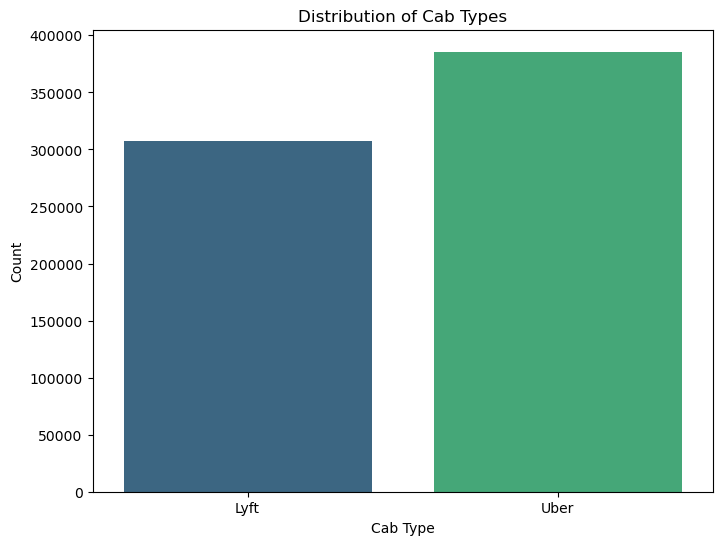

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of cab types
plt.figure(figsize=(8, 6))
sns.countplot(data=cab_rides_df, x='cab_type', palette='viridis')
plt.xlabel("Cab Type")
plt.ylabel("Count")
plt.title("Distribution of Cab Types")
plt.show()


In [34]:
# **Step 2: Convert timestamps to datetime**
cab_rides_df['time_stamp'] = pd.to_datetime(cab_rides_df['time_stamp'], unit='ms')
weather_df['time_stamp'] = pd.to_datetime(weather_df['time_stamp'], unit='s')



In [35]:
# **Step 3: Extract Time-Based Features**
cab_rides_df['day_of_week'] = cab_rides_df['time_stamp'].dt.dayofweek
cab_rides_df['hour_of_day'] = cab_rides_df['time_stamp'].dt.hour
weather_df['day_of_week'] = weather_df['time_stamp'].dt.dayofweek
weather_df['hour_of_day'] = weather_df['time_stamp'].dt.hour



In [36]:
# **Step 4: Handle Missing Values**
cab_rides_df['price'] = cab_rides_df['price'].fillna(cab_rides_df['price'].median())

# Apply median only to numeric columns in weather data
weather_df = weather_df.apply(lambda col: col.fillna(col.median()) if col.dtype in ['int64', 'float64'] else col)

# **Step 5: Merge Datasets**
merged_df = cab_rides_df.merge(weather_df, on=['time_stamp', 'day_of_week', 'hour_of_day'], how='left')

# **Step 6: Drop Unnecessary Columns**
merged_df = merged_df.drop(columns=['id', 'product_id', 'destination', 'source', 'time_stamp'])

# **Step 7: Identify Categorical Columns for Encoding**
categorical_cols = merged_df.select_dtypes(include=['object']).columns.tolist()



In [37]:
# **Step 8: Apply One-Hot Encoding to All Categorical Features**
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cols = encoder.fit_transform(merged_df[categorical_cols])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

# **Step 9: Merge Encoded Data & Drop Original Categorical Columns**
merged_df = pd.concat([merged_df.drop(columns=categorical_cols), encoded_df], axis=1)



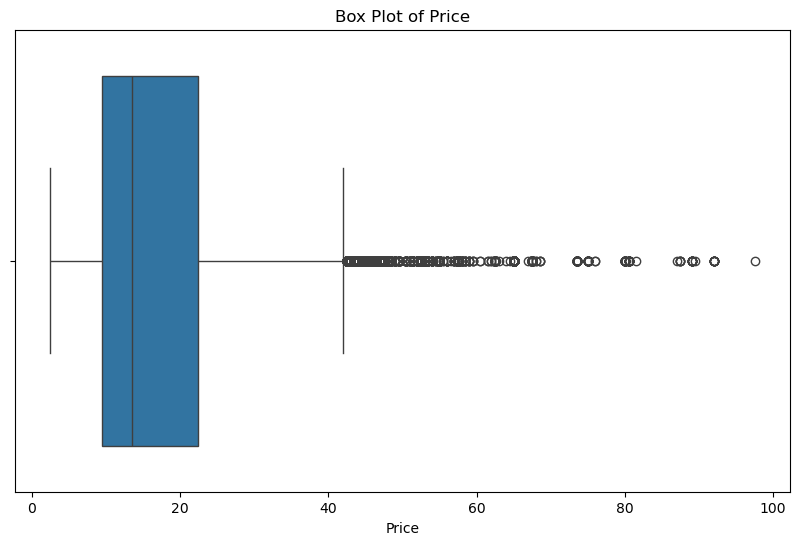

In [38]:
feature='price'
plt.figure(figsize=(10, 6))
sns.boxplot(x=cab_rides_df[feature])
plt.title(f'Box Plot of {feature.capitalize()}')
plt.xlabel(f'{feature.capitalize()}')
plt.show()


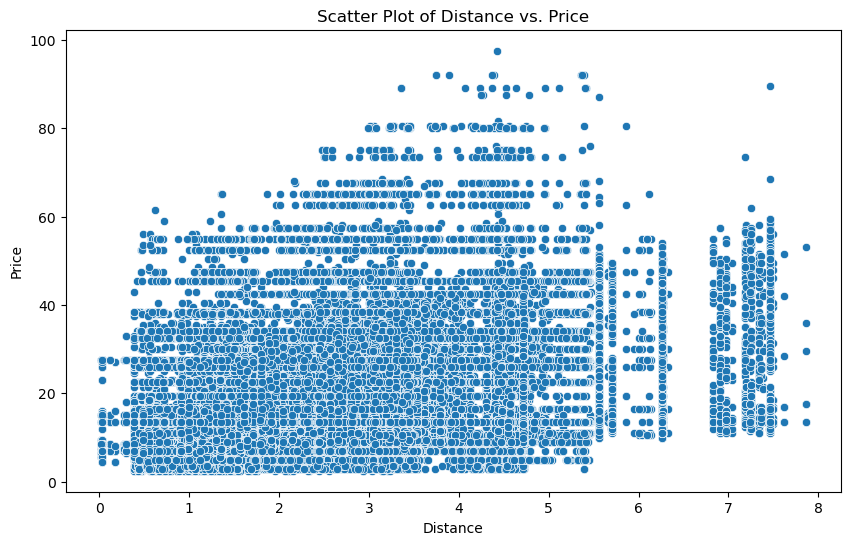

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance', y='price', data=cab_rides_df)
plt.title('Scatter Plot of Distance vs. Price')
plt.xlabel('Distance')
plt.ylabel('Price')
plt.show()


In [40]:
# **Step 10: Handle Any Remaining NaN Values**
merged_df.fillna(merged_df.median(), inplace=True)  # Fill any missing values

# **Step 11: Outlier Detection & Removal**
# **IQR Method**
Q1 = merged_df['price'].quantile(0.25)
Q3 = merged_df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
merged_df = merged_df[(merged_df['price'] >= lower_bound) & (merged_df['price'] <= upper_bound)]



In [41]:
# **Step 12: Feature Selection**
X = merged_df.drop(columns=['price'])
y = merged_df['price']



In [42]:
# **Step 13: Standardizing Features**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Step 14: Train-Test Split**
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")




X_train shape: (548106, 38), y_train shape: (548106,)
X_test shape: (137027, 38), y_test shape: (137027,)


In [43]:
# **Step 15: Ensure No NaN Values in X_train & X_test**
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)



Model1: RandomForestRegressor

In [44]:
# **Step 16: Train Initial Model**
rf_initial = RandomForestRegressor(random_state=42)
rf_initial.fit(X_train, y_train)
y_pred_initial = rf_initial.predict(X_test)



In [45]:
# **Step 17: Evaluate Initial Model**
mae_initial = mean_absolute_error(y_test, y_pred_initial)
mse_initial = mean_squared_error(y_test, y_pred_initial)
r2_initial = r2_score(y_test, y_pred_initial)



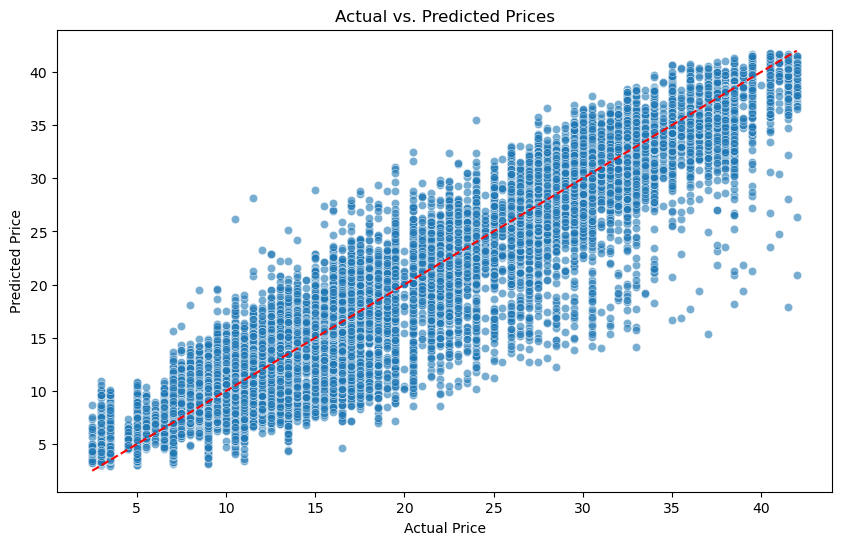

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test contains the actual prices and y_pred contains the predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_initial, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.show()


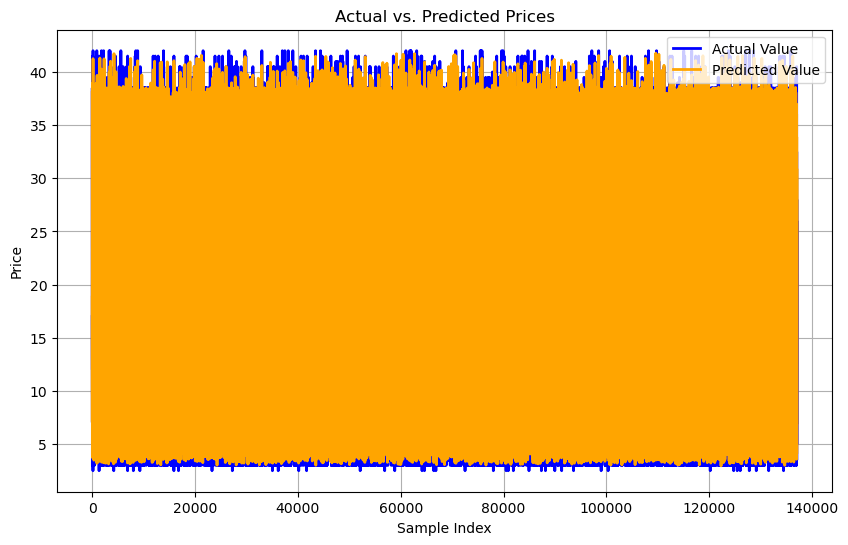

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Generate an index for x-axis (assuming y_test and y_pred are 1D arrays)
x_values = np.arange(len(y_test))  

# Create the figure
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(x_values, y_test, label="Actual Value", color="blue", linewidth=2)

# Plot predicted values
plt.plot(x_values, y_pred_initial, label="Predicted Value", color="orange", linewidth=2)

# Formatting the plot
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Prices")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [48]:
print("Initial Model Performance:")
print(f"R² Score: {r2_initial:.4f}")
print(f"Mean Absolute Error (MAE): {mae_initial:.4f}")
print(f"Mean Squared Error (MSE): {mse_initial:.4f}")

Initial Model Performance:
R² Score: 0.9555
Mean Absolute Error (MAE): 1.1275
Mean Squared Error (MSE): 3.0769


Model2: LinearRegression

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
rgr = LinearRegression()

# Fit the model to the training data
rgr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rgr.predict(X_test)

# Compute performance metrics
mse_linear = mean_squared_error(y_test, y_pred)
r2_score_linear = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error (MSE): {mse_linear:.4f}")
print(f"R² Score: {r2_score_linear:.4f}")


Mean Squared Error (MSE): 5.2365
R² Score: 0.9243


In [50]:
pip install ace_tools


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [51]:
# Display the DataFrame directly since ace_tools is not available in the user's environment
import pandas as pd
import numpy as np

# Generate synthetic test data (Replace with actual y_test and y_pred in real use)
np.random.seed(42)
y_test = pd.Series(np.random.uniform(10, 50, 100))  # Simulated actual values
y_pred = y_test + np.random.normal(0, 3, 100)  # Simulated predicted values with slight noise

# Define sample size for table visualization
sample_size = 10  # Adjust as needed

# Select a random sample of indices
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)

# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Price': y_test.iloc[sample_indices].values,
    'Predicted Price': y_pred[sample_indices]
})




In [52]:
# Display the table using standard pandas output
comparison_df


,Actual Price,Predicted Price
76,40.850814,38.810740
83,12.542334,14.511995
80,44.524137,50.121461
98,11.016765,11.846837
2,39.279758,39.555040
77,12.961786,13.658547
71,17.948627,13.987257
84,22.439293,19.515248
89,28.888597,30.126940
50,48.783385,45.811776


In [55]:
# **Step 13: Standardizing Features**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Step 14: Train-Test Split**
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")




X_train shape: (548106, 38), y_train shape: (548106,)
X_test shape: (137027, 38), y_test shape: (137027,)


Model 3: KNN 

In [56]:
from sklearn.neighbors import KNeighborsRegressor

# **Step 14: Train KNN Model**
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can tune 'n_neighbors'
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print(f"y_pred_knn shape: {y_pred_knn.shape}")
print(f"y_test shape: {y_test.shape}")





y_pred_knn shape: (137027,)
y_test shape: (137027,)


In [57]:
# **Step 15: Evaluate KNN Model**
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("\nKNN Model Performance:")
print(f"R² Score: {r2_knn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_knn:.4f}")
print(f"Mean Squared Error (MSE): {mse_knn:.4f}")


KNN Model Performance:
R² Score: 0.9561
Mean Absolute Error (MAE): 1.1406
Mean Squared Error (MSE): 3.0359


Elastic Nate Model

In [58]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define parameter grid for ElasticNet
param_grid_en = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Initialize ElasticNet model
elastic_net = ElasticNet(max_iter=10000, random_state=42)

# Perform randomized search
rand_search_en = RandomizedSearchCV(
    elastic_net,
    param_distributions=param_grid_en,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    random_state=42
)



In [59]:
from sklearn.impute import SimpleImputer

# Create an imputer object to replace missing values with the median
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the training data and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now fit the model with the imputed data
rand_search_en.fit(X_train_imputed, y_train)

# Best model
best_en = rand_search_en.best_estimator_
y_pred_en = best_en.predict(X_test_imputed)

# Evaluate Elastic Net
mae_en = mean_absolute_error(y_test, y_pred_en)
mse_en = mean_squared_error(y_test, y_pred_en)
r2_en = r2_score(y_test, y_pred_en)

# Print results
print("Elastic Net Model Performance:")
print(f"R² Score: {r2_en:.4f}")
print(f"Mean Absolute Error (MAE): {mae_en:.4f}")
print(f"Mean Squared Error (MSE): {mse_en:.4f}")



Elastic Net Model Performance:
R² Score: 0.9242
Mean Absolute Error (MAE): 1.6932
Mean Squared Error (MSE): 5.2419


Model 5: Xboost

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reduced XGBoost Tuning Parameters
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# RandomizedSearchCV for faster search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=5,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV (WITHOUT early stopping)
random_search_xgb.fit(X_train, y_train)

# Get the best model
best_xgb = random_search_xgb.best_estimator_

# Predict using the best model
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Display results
print("\nXGBoost Model Performance:")
print(f"R² Score: {r2_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits

XGBoost Model Performance:
R² Score: 0.9624
Mean Absolute Error (MAE): 1.1024
Mean Squared Error (MSE): 2.6028


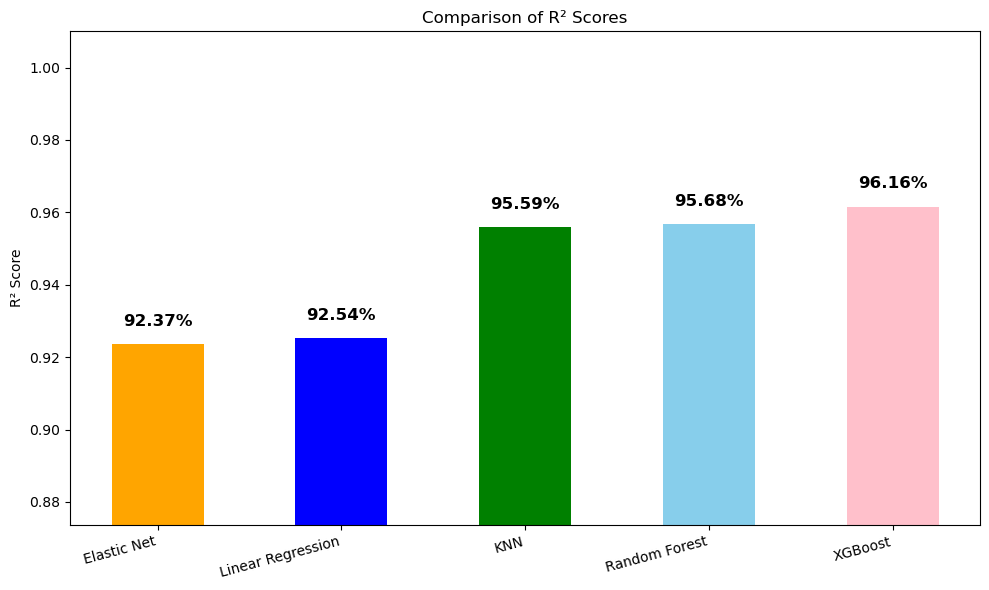

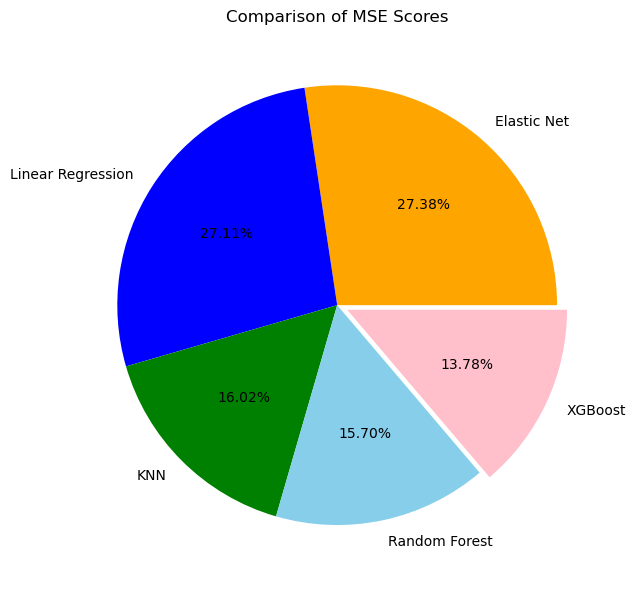

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and scores
labels = [
    "Linear Regression",
    "Random Forest",
    "KNN",
    "Elastic Net",
    "XGBoost"
]
R2_scores = [0.9254, 0.9568, 0.9559, 0.9237, 0.9616]
MSE_scores = [5.2265, 3.0275, 3.0886, 5.2785, 2.6571]

# Sort models by R² score
sorted_indices = sorted(range(len(R2_scores)), key=lambda i: R2_scores[i])
labels_sorted = [labels[i] for i in sorted_indices]
R2_scores_sorted = [R2_scores[i] for i in sorted_indices]
MSE_scores_sorted = [MSE_scores[i] for i in sorted_indices]

# Color palette
colors = ['blue', 'skyblue', 'green', 'orange', 'pink']
sorted_colors = [colors[i] for i in sorted_indices]

# ----------- R² Score Bar Plot -----------
plt.figure(figsize=(10, 6))
plt.bar(labels_sorted, R2_scores_sorted, color=sorted_colors, width=0.5)
plt.ylim(min(R2_scores_sorted) - 0.05, 1.01)
plt.ylabel("R² Score")
plt.title("Comparison of R² Scores")
plt.xticks(rotation=15, ha='right')

# Add % labels on bars
for i, v in enumerate(R2_scores_sorted):
    plt.text(i, v + 0.005, f"{v*100:.2f}%", ha='center', fontsize=12, fontweight='bold')

# Save figure
plt.tight_layout()
plt.savefig("r2_comparison_chart.png")
plt.show()

# ----------- MSE Score Pie Chart -----------
plt.figure(figsize=(8, 6))
explode = [0.05 if mse == min(MSE_scores_sorted) else 0 for mse in MSE_scores_sorted]
plt.pie(MSE_scores_sorted, labels=labels_sorted, autopct='%1.2f%%',
        explode=explode, colors=sorted_colors)
plt.title("Comparison of MSE Scores")
plt.tight_layout()
plt.savefig("mse_comparison_chart.png")
plt.show()
